## Annual Water Case

**Deskripsi Dataset :** <br>
Dataset yang digunakan merupakan data penggunaan air tahunan di Baltimore dari tahun 1885 hingga 1963 data. Dataset yang digunakan terdiri dari 2 variabel yakni year dan annual water use.  <br>

**Deskripsi Project :** <br>
Pada case ini akan dilakukan prediksi mengenai penggunaan air dengan menggunakan ARIMA berdasarkan rata-rata penggunaan air ditahun sebelumnya.

### **1. Import Library dan Load Dataset**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import Grouper
import warnings
warnings.filterwarnings('ignore')

In [13]:
AW=pd.read_csv('water (1).csv')
AW.head()

,Year,"Baltmore city annual water use, liters per capita per day, 1885-1968"
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413


Setelah melakukan penginputan data, selanjutnya akan membagi data menjadi 2, yakni untuk membangun model dengan nama file dataset, dan data lainnya untuk validasi dengan nama file validation dengan proporsi pembagian 70% untuk dataset dan 30% untuk data validasi.

In [14]:
from pandas import read_csv

In [22]:
data1 = read_csv('water (1).csv',header=0)
data1.head()

,Year,"Baltmore city annual water use, liters per capita per day, 1885-1968"
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413


In [23]:
split_point = int(len(AW)*0.7)
dataset, validation = data1[0:split_point], data1[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', index=False)
validation.to_csv('validation.csv', index=False)

Dataset 55, Validation 24


Jumlah data yang berada pada dataset sebanyak 55 data yakni sejak tahun 1885 hingga tahun 1939 dan pada validation sebanyak 24 data yakni sejak tahun 1940 hingga 1963.

### **2. Summary Dataset**

Summary dataset digunakan untuk mengetahui karakteristik dari data. Summary berisikan ukuran pemusatan dan penyebaran data seperti rata-rata, standar deviasi, minimum, maksimum, Q1,Q2, dan Q3

In [25]:
dataset=pd.read_csv('dataset.csv')
dataset = dataset.set_index(dataset['Year'])
dataset.drop(columns=['Year'], inplace=True)
dataset.describe()

,"Baltmore city annual water use, liters per capita per day, 1885-1968"
count,55.000000
mean,476.254545
std,60.823429
min,344.000000
25%,452.000000
50%,473.000000
75%,503.000000
max,662.000000


### **3. Time series Plot**

Time series plot dapat digunakan untuk mengetahui kondisi awal dari data yang akan digunakan. Apakah terdapat tren, atau membentuk pola tertentu secara visual.

In [27]:
from matplotlib.pylab import rcParams

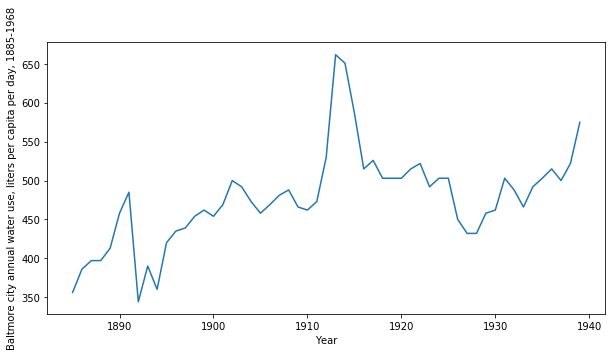

In [33]:
rcParams['figure.figsize'] = (10, 5)
plt.xlabel('Year')
plt.ylabel('Baltmore city annual water use, liters per capita per day, 1885-1968')
plt.plot(dataset['Baltmore city annual water use, liters per capita per day, 1885-1968'])
plt.show()

- Penggunaan air dalam 79 tahun memiliki tren yang naik meskipun dibeberapa tahun terdapat penurunan.
- Fluktuasi cenderung tinggi.

### **4. Group Annual Data by Decade**

**Histogram**

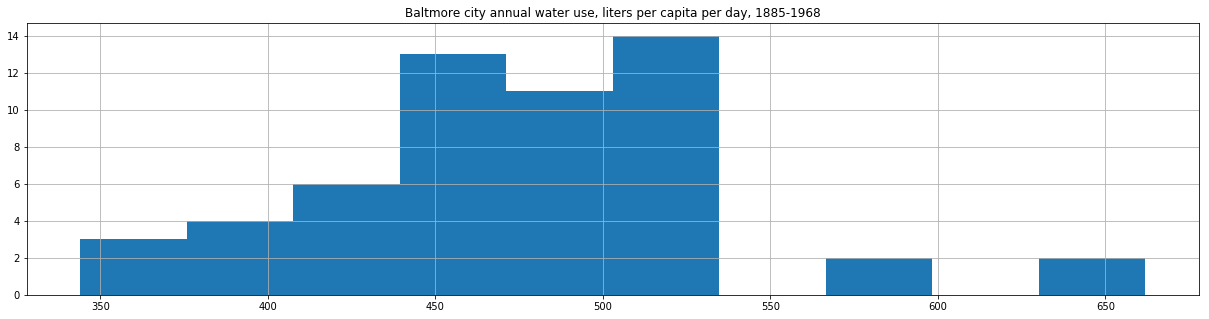

In [35]:
rcParams['figure.figsize'] = (21, 5)
dataset.hist()
plt.show()

**Density Plot**

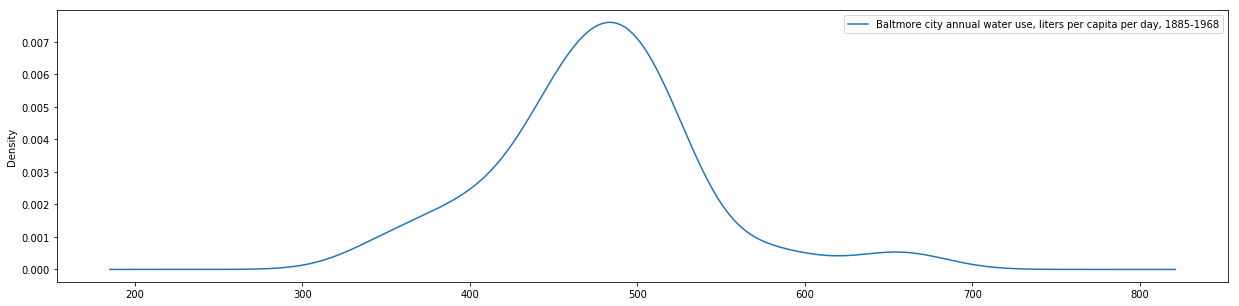

In [36]:
rcParams['figure.figsize'] = (21, 5)
dataset.plot(kind='kde')
plt.show()

Dikarenakan data membentuk pola menyerupai lonceng maka diketahui data memiliki distribusi normal.

In [37]:
dataset = dataset.reset_index()
dataset['Year'].unique()

array([1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895,
       1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906,
       1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917,
       1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928,
       1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939],
      dtype=int64)

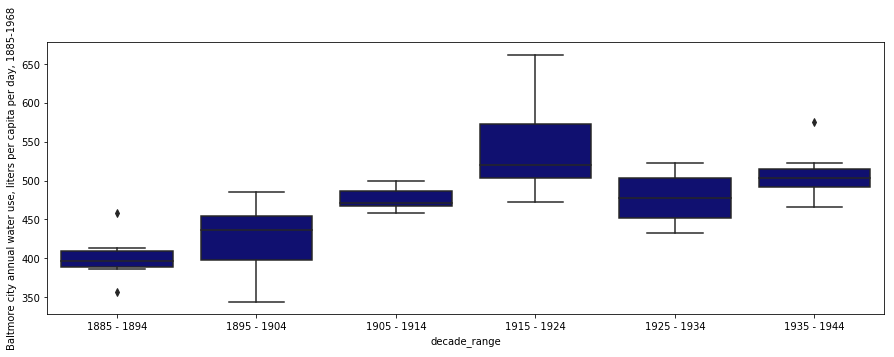

In [42]:
# NEAREST 10 FOR DECADE START
dataset['decade_start'] = (dataset['Year'] // 10) * 10 + 5
dataset.loc[(dataset['Year'] % 10) == 0, 'decade_start'] = dataset['decade_start'] - 10
dataset['decade_range'] = dataset['decade_start'].astype('str') + ' - ' + \
                     (dataset['decade_start'] + 9).astype('str') 
plt.figure(figsize=(15,5))
sns.boxplot(x="decade_range", y="Baltmore city annual water use, liters per capita per day, 1885-1968", data=dataset, color = 'navy')   

plt.show()
plt.clf()
plt.close()

Jumlah data yang ada pada dataset sebanyak 55 data dan akan dibagi menjadi enam dekade sehingga range tahun dari masing-masing dekade adalah sebanyak 10 tahun. <br>
- Nilai median untuk setiap dekade menunjukkan trend meningkat.
- terindikasi adanya outlier pada beberapa data kapasitas pengguna air (dekade 1 dan 6)

### **5. Modelling Using ARIMA**

In [43]:
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [44]:
dataset = read_csv('dataset.csv')
dataset['Year'] = pd.to_datetime(dataset['Year'], format='%Y')
dataset = dataset.set_index(dataset['Year'])
dataset.drop(columns=['Year'], inplace=True)
dataset = dataset.astype('float64')

**Split data menjadi data training dan testing dengan proporsi 50% : 50%**

In [45]:
train_size = int(len(dataset)*0.5)
train = dataset[0:train_size]
test = dataset[train_size:]
print(train.shape)
print(test.shape)

(27, 1)
(28, 1)


Pada data training terdapat 27 data dan untuk data testing terdapat 28 data.

Langkah pertama adalah melakuka pemodelan dengan parameter ARIMA (0,1,0)

In [58]:
model = ARIMA(train, order=(0,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

IndexError: list index out of range

Pemodelan dengan ARIMA (0,1,0) menghasilkan output eror sehingga perlu dilakukan penghitungan parameter ARIMA (p,d,q)

Langkah yang dapat dilakukan untuk mengetahui parameter p,d,q pada ARIMA, maka dapat dilihat melalui plot ACF dan PACF. Namun sebelum mencari plot ACF dan PACF maka perlu dilakukan pengujian stasioneritas terhadap data.

**Uji Stasioner**

In [49]:
rolmean = pd.rolling_mean(train, window=12)
rolstd = pd.rolling_std(train, window=12)
print(rolmean, rolstd)

            Baltmore city annual water use, liters per capita per day, 1885-1968
Year                                                                            
1885-01-01                                                NaN                   
1886-01-01                                                NaN                   
1887-01-01                                                NaN                   
1888-01-01                                                NaN                   
1889-01-01                                                NaN                   
1890-01-01                                                NaN                   
1891-01-01                                                NaN                   
1892-01-01                                                NaN                   
1893-01-01                                                NaN                   
1894-01-01                                                NaN                   
1895-01-01                  

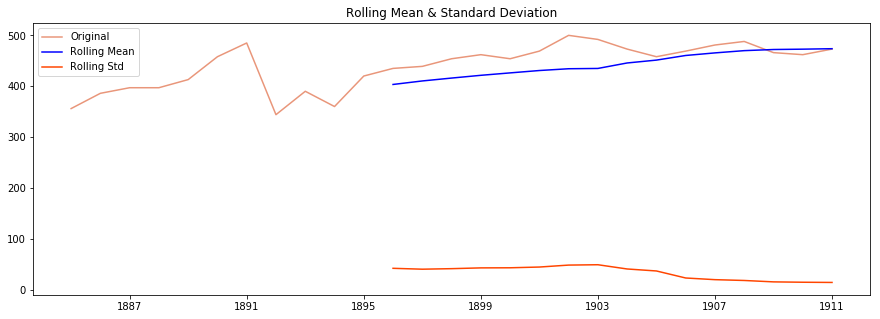

In [50]:
plt.figure(figsize=(15,5))
orig = plt.plot(train, color='darksalmon',label='Original')
mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
std = plt.plot(rolstd, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Dari plot tersebur diketahui bahwa data telah stasioner dalam mean, namun belum stasioner dalam ragam sehingga dilakukan uji Dicky-Fuller dengan hipotesis : <br>
H0 : Data tidak stasioner <br>
H1 : Data stasioner

In [55]:
from statsmodels.tsa.stattools import adfuller
print ('Statistik Uji Dickey-Fuller Test:')
dftest = adfuller(train['Baltmore city annual water use, liters per capita per day, 1885-1968'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)' %key] = value
  
print(dfoutput)

Statistik Uji Dickey-Fuller Test:
Test Statistic                 -2.689200
p-value                         0.075926
Lags Used                       0.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


Diketahui bahwa dengan melakukan pengujian Dicky Fuller, menghasilkan p-value sebesar 0,07 dimana nilai tersebut lebih besar daripada 0,05. <br>
Keputusan : Gagal Tolak H0 <br>
Kesimpulan : Data tidak stasioner

**Plot ACF dan PACF**

Plot ACF dan PACF digunakan untuk mengetahui parameter pada (p,q)

In [47]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

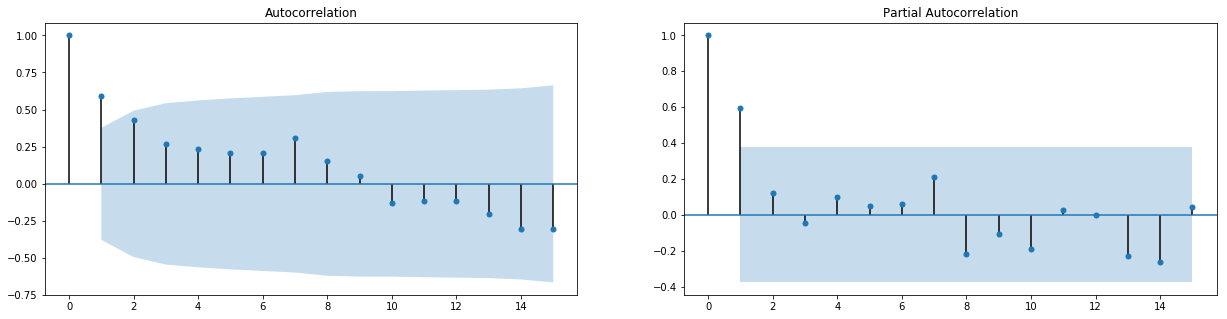

In [48]:
pyplot.figure()
pyplot.subplot(121)
plot_acf(train, ax=pyplot.gca(), lags = 15)
pyplot.subplot(122)
plot_pacf(train, ax=pyplot.gca(), lags = 15)
pyplot.show()

Dari plot ACF dan PACF dapat diketahui bahwa data tidak memiliki pola seasonal. Pada pola PACF diketahui data keluar pada lag ke 1 sehingga parameter p adalah 1. <br>
Sehingga model yang dapat terbentuk : <br>
**ARIMA(0,1,1)**

In [56]:
model1 = ARIMA(train, order=(0,1,1))
model_fit = model1.fit(disp=0)
print(model_fit.summary())

                                                       ARIMA Model Results                                                        
Dep. Variable:     D.Baltmore city annual water use, liters per capita per day, 1885-1968   No. Observations:                   26
Model:                                                                     ARIMA(0, 1, 1)   Log Likelihood                -127.663
Method:                                                                           css-mle   S.D. of innovations             30.810
Date:                                                                    Thu, 10 Oct 2019   AIC                            261.327
Time:                                                                            17:49:37   BIC                            265.101
Sample:                                                                        01-01-1886   HQIC                           262.414
                                                                             - 01-0

Diketahui bahwa p-value yang dihasilkan 0,000 sehingga diketahui bahwa **parameter telah signifikan.**

In [60]:
y_pred = model_fit.forecast(len(test))[0]
df_test = pd.DataFrame(y_pred, columns=['prediksi'], index=test.index)
df_test['aktual'] = test.values
df_test

,prediksi,aktual
Year,,
1912-01-01,477.5,530.0
1913-01-01,482.0,662.0
1914-01-01,486.5,651.0
1915-01-01,491.0,587.0
1916-01-01,495.5,515.0
1917-01-01,500.0,526.0
1918-01-01,504.5,503.0
1919-01-01,509.0,503.0
1920-01-01,513.5,503.0


**Plot prediksi vs aktual**

In [63]:
mse = mean_squared_error(df_test['aktual'], df_test['prediksi'])
rmse = np.sqrt(mse)
rmse

80.6999513188028

Diketahui RMSE dari prediksi yang terbentuk adalah 80,69. Nilai RMSE yang masih tinggi disebabkan karena pembagian data training dan data testing yang sama. Seharusnya data training yang digunakan memiliki proporsi lebih besar dibandingkan dengan data testing. Sehingga menyebabkan nilai prediksi belum mendekati nilai aktual.